# <!--BOOK_INFORMATION-->

This notebook is based on and adapted from the following sources:
* [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook) by Jake VanderPlas, licensed under the [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode) and [MIT](https://opensource.org/licenses/MIT) licenses;
* [Google Colab tutorials](https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb).


# Regularized regression

Linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

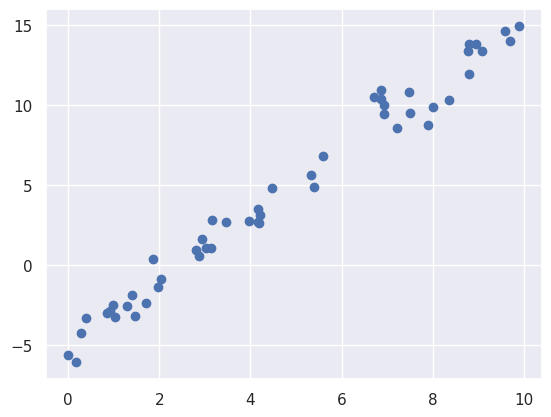

In [ ]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50,1)
y = 2 * x - 5 + rng.randn(50,1)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

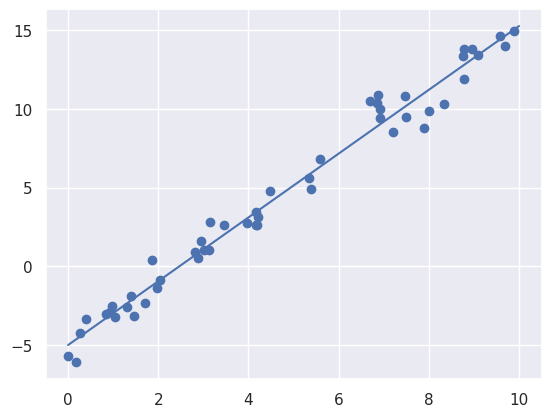

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x, y)

xfit = np.linspace(0, 10, 1000).reshape(1000,1) # or add dimension  x[:,np.newaxis]
yfit = model.predict(xfit)

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [ ]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [2.02720881]
Model intercept: [-4.99857709]


We see that the results are very close to the inputs, as we might hope.

The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [ ]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
noise = 3* rng.rand(100,)
y = 0.5 + np.dot(X, [1.5, -2., 1.]) + noise

model.fit(X, y)
print("Intercept: ", model.intercept_)
print("Coeff: ", model.coef_)

Intercept:  2.3169851225792435
Coeff:  [ 1.45208705 -1.98710567  0.97334897]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

We can use some of the built-in metrics to evaluate the mean squared error of the models, or do it manually.

In [ ]:
from sklearn.metrics import mean_squared_error
yhat = model.predict(X)

auto_mse = mean_squared_error(y, yhat)
manual_mse = np.mean( (y - yhat) ** 2)

print (auto_mse, manual_mse)

0.6802604583751257 0.6802604583751257


In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
One version of this is the ``PolynomialRegression`` pipeline.
The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial basis function is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
x = x[:, None] # another alternative to using np.newaxis
y = np.sin(x)
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x)

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

Or on multiple columns at once. Notice that you get all interaction terms up to degree 3.

In [ ]:
x = np.array([[2,1], [2,2],[2,3]])
y = np.sin(x)
poly = PolynomialFeatures(3, include_bias=False)
x2 = poly.fit_transform(x)

print('Before\n', x, '\nAfter\n', poly.get_feature_names_out())
print(x2)

Before
 [[2 1]
 [2 2]
 [2 3]] 
After
 ['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3']
[[ 2.  1.  4.  2.  1.  8.  4.  2.  1.]
 [ 2.  2.  4.  4.  4.  8.  8.  8.  8.]
 [ 2.  3.  4.  6.  9.  8. 12. 18. 27.]]


##Pipelines
We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to accomplish this is to use a pipeline.
Let's add degree 3 polynomial features to our model and standardize the feature before fitting a linear regression:

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(PolynomialFeatures(3, include_bias=False),\
                     StandardScaler(), \
                     LinearRegression())
pipe.fit(x,y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Calling `fit` on a pipeline has the same effect as calling `fit` and `transform` on the first transformer in the pipe, taking the output and calling `fit` and `transform` on the second transformer, etc., until finally calling `fit` on the the estimator (which should always be the final step in the pipeline). It may be useful to visualize what happens to our original x as it passes through the pipeline:

In [ ]:
print('Original data: \n', x)
x_intermediate = x

# for each of the transformations, print the data
for step in pipe.steps[:-1]: # the last step in the pipeline is an estimator
    x_intermediate = step[1].fit_transform(x_intermediate)
    print('After',  step[0], '\n',  step[1].get_feature_names_out(), '\n',  x_intermediate.round(2))

print('Feature names', pipe[:-1].get_feature_names_out() )

Original data: 
 [[2 1]
 [2 2]
 [2 3]]
After polynomialfeatures 
 ['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3'] 
 [[ 2.  1.  4.  2.  1.  8.  4.  2.  1.]
 [ 2.  2.  4.  4.  4.  8.  8.  8.  8.]
 [ 2.  3.  4.  6.  9.  8. 12. 18. 27.]]
After standardscaler 
 ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8'] 
 [[ 0.   -1.22  0.   -1.22 -1.11  0.   -1.22 -1.11 -1.  ]
 [ 0.    0.    0.    0.   -0.2   0.    0.   -0.2  -0.36]
 [ 0.    1.22  0.    1.22  1.31  0.    1.22  1.31  1.37]]
Feature names ['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3']


Now let's use a pipeline to automate adding polynomial so that we can  (hopefully) use the linear model to fit much more complicated relationships between $x$ and $y$.
For example, here is a sine wave with noise:

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# generate data
rng = np.random.RandomState(42)
n = 80
noise = 0.2  #0.1, 0.5
x = 10 * rng.rand(n,1)
y = np.sin(x) + noise * rng.randn(n,1)
xfit = np.linspace(0,10,100).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


MSE on X_train:  0.02694999506345868
MSE on X_test:  0.0830611712493287
Coefficient norm: 1056806096076.1221


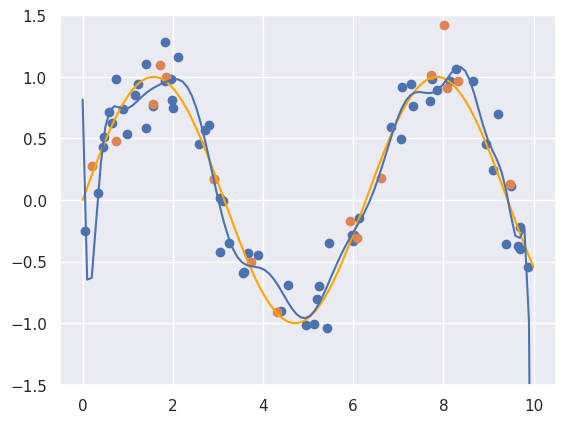

In [ ]:
poly_pipe = make_pipeline(PolynomialFeatures(21, include_bias=False),\
                     StandardScaler(), \
                     LinearRegression()) #compare degree 5, 21

# add polynomial features, fit model and predict
poly_pipe.fit(x_train , y_train)
yfit = poly_pipe.predict(xfit);

# visualize results
plt.scatter(x_train , y_train)
plt.scatter(x_test , y_test)
plt.plot(xfit, np.sin(xfit), c='orange')
plt.plot(xfit, yfit);
plt.ylim(-1.5,1.5)
print('MSE on X_train: ', mean_squared_error( poly_pipe.predict(x_train), y_train ) )
print('MSE on X_test: ', mean_squared_error( poly_pipe.predict(x_test), y_test ) )
print("Coefficient norm:", np.linalg.norm(poly_pipe['linearregression'].coef_))

In [ ]:
poly_pipe[-1].coef_

array([[-8.25036625e+01,  4.96793570e+03, -1.13369833e+05,
         1.29245923e+06, -6.20907315e+06, -2.63283956e+07,
         6.47384734e+08, -5.21066682e+09,  2.59219220e+10,
        -8.92822989e+10,  2.20340729e+11, -3.88386552e+11,
         4.64128988e+11, -3.00345429e+11, -7.88998811e+10,
         4.27708735e+11, -5.12940257e+11,  3.55145546e+11,
        -1.52608902e+11,  3.80473392e+10, -4.23530369e+09]])

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data! However, if we made the model too flexible, say by using 31-st order basis functions, it may do significantly worse.

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.
For example, if we choose too many polynomial basis functions, as above, then we end up with a model that does well on the test set but not the training set.

The model has far too much flexibility and goes to extreme values between locations where it is constrained by data.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be
$$
P = \alpha\sum_{j=1}^p \beta_j^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

In [ ]:
from sklearn.linear_model import Ridge

MSE on X_train:  0.20485965141703577
MSE on X_test:  0.1762543601260439
Coefficient norm: 1.5609728138440053


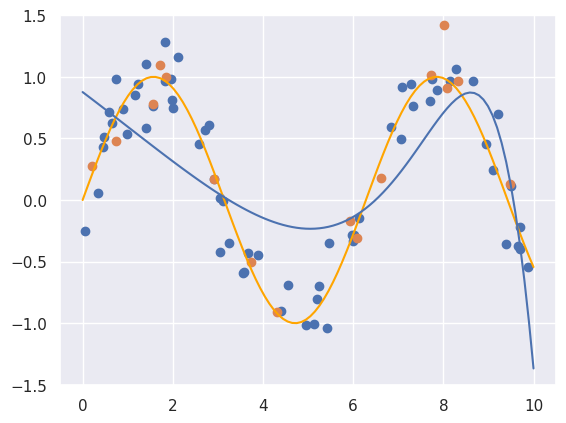

In [ ]:
model = make_pipeline(PolynomialFeatures(21),
                      StandardScaler(with_mean=False),
                      Ridge(alpha=10e-1) ) #try 10^{0, -1,-3,-6}
# add polynomial features, fit model and predict
model.fit(x_train , y_train)
yfit = model.predict(xfit);

# visualize results
plt.scatter(x_train , y_train)
plt.scatter(x_test , y_test)
plt.plot(xfit, np.sin(xfit), c='orange')
plt.plot(xfit, yfit);
plt.ylim(-1.5,1.5)
print('MSE on X_train: ', mean_squared_error( model.predict(x_train), y_train ) )
print('MSE on X_test: ', mean_squared_error( model.predict(x_test), y_test ) )
print("Coefficient norm:", np.linalg.norm(model['ridge'].coef_))

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{j=1}^p |\beta_j|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

MSE on X_train:  0.21324770975220791
MSE on X_test:  0.18875431963265726
Coefficient norm: 2.114605972148432


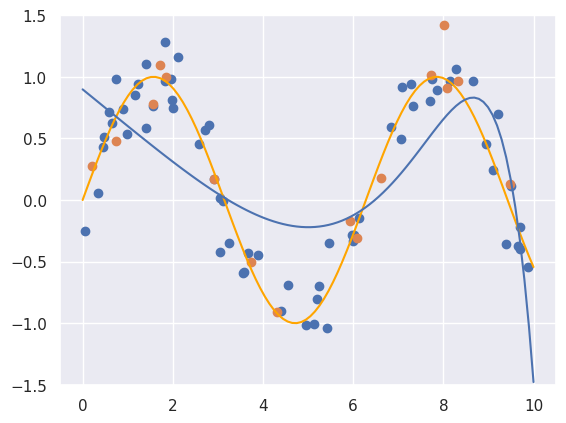

In [ ]:
from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(21),
                      StandardScaler(with_mean=False),
                      Lasso(alpha=10e-3, max_iter=10000) ) #try lambda = 10^-{1,3,5}

model.fit(x_train , y_train)
yfit = model.predict(xfit);

# visualize results
plt.scatter(x_train , y_train)
plt.scatter(x_test , y_test)
plt.plot(xfit, np.sin(xfit), c='orange')
plt.plot(xfit, yfit);
plt.ylim(-1.5,1.5)
print('MSE on X_train: ', mean_squared_error( model.predict(x_train), y_train ) )
print('MSE on X_test: ', mean_squared_error( model.predict(x_test), y_test ) )
print("Coefficient norm:", np.linalg.norm(model['lasso'].coef_))

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

We will discuss cross-validation in more detail in future weeks. For now, let's just use a simple loop to investigate the effect of changing the regularization strength.

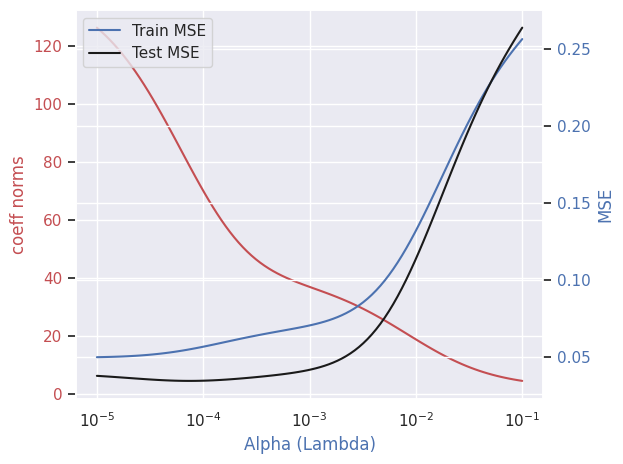

In [ ]:
# Do not do this in your project
lambda_vals = np.logspace(-5,-1,100)
norms = []
train_mses, test_mses = [], []

for a in lambda_vals:
  model = make_pipeline(PolynomialFeatures(5), \
                        StandardScaler(with_mean=False),\
                        Ridge(alpha=a, max_iter=10000))
  model.fit(x_train, y_train)
  norms.append(np.linalg.norm(model[-1].coef_))
  train_mses.append(mean_squared_error(model.predict(x_train),y_train))
  test_mses.append(mean_squared_error(model.predict(x_test),y_test))

fig, ax1 = plt.subplots()

ax1.set_xlabel('Alpha (Lambda)', color='b')
ax1.set_ylabel('coeff norms', color='r')
ax1.set_xscale('log')
ax1.plot(lambda_vals, np.array(norms), color='r', label='Size of coeff.')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('MSE', color='b')  #  already handled the x-label
ax2.plot(lambda_vals, np.array(train_mses), color='b', label='Train MSE')
ax2.plot(lambda_vals, np.array(test_mses), color='k', label='Test MSE')
ax2.tick_params(axis='y', labelcolor='b')

plt.legend()
fig.tight_layout()
plt.show()